<h2><center><strong>Ecole Polytechnique de Tunisie</strong></center></h2> 
<img src="EPT.jpg" style="width:80px;height:80px" >


<h1><center><em>Data Analysis - Final project</em></center></h1>
<h2><center><em>Elaborated by :</em> <font color='blue'> Malek Mechergui</font></center></h2> 
          

The goal of the final project is to predict next day's returns using daily stock data from Tunisia Stock Exchange. The evaluation metric for this competition is the RMSE.

You need to make sure that you use a linear regression model along with the topics that we covered in class (Data visualization, correlation, PCA, FA, Residual Analysis...)

Link to the kaggle competition : https://www.kaggle.com/t/14f956bf170e463dadbcb58bb3f36540


## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
import warnings 
warnings.filterwarnings("ignore")

## Read and explore data

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

I concatenated both the train and the test sets in order to pre-process and manipluate one dataset.

In [3]:
train_len = len(train)
all_data = pd.concat([train,test])
all_data.head()

,Id,close,company,company_code,date,high,last,low,next_day_ret,num_trades,open,qty_traded,value,yesterday_price
0,0,5.39,ADWYA,725001,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,2926,15635.50,5.35
1,1,24.00,AMEN BANK,340005,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,1519,36918.00,24.35
2,2,6.10,ARTES,730001,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,35875,219020.05,6.20
3,3,9.00,ASSAD,714001,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,0,NaN,9.00
4,4,4.18,ATB,360035,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,3705,15465.90,4.22


I added currReturn and nextReturn that we saw in homeworks.

In [4]:
all_data['currReturn'] = all_data.groupby(['company'])['close'].pct_change()
all_data['nextReturn'] = all_data.groupby(['company'])['currReturn'].shift(-1)

#data process

all_data['date'] = pd.to_datetime(all_data['date'], format='%Y-%m-%d')
all_data.head()

,Id,close,company,company_code,date,high,last,low,next_day_ret,num_trades,open,qty_traded,value,yesterday_price,currReturn,nextReturn
0,0,5.39,ADWYA,725001,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,2926,15635.50,5.35,NaN,-0.007421
1,1,24.00,AMEN BANK,340005,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,1519,36918.00,24.35,NaN,-0.000417
2,2,6.10,ARTES,730001,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,35875,219020.05,6.20,NaN,0.024590
3,3,9.00,ASSAD,714001,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,0,NaN,9.00,NaN,-0.001111
4,4,4.18,ATB,360035,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,3705,15465.90,4.22,NaN,-0.007177


Lets take a look to the missing values in our dataset.

In [5]:
all_data.isnull().sum()

Id                     0
close                  0
company                0
company_code           0
date                   0
high                   0
last                   0
low                    0
next_day_ret       20331
num_trades             0
open                   0
qty_traded             0
value              10052
yesterday_price        0
currReturn            82
nextReturn            82
dtype: int64

- next_day_ret have 20331 missing values which's exactly the length of the testset.

- value have 10052. Visualizating techniques and the correlation of value to both the features and the target are going to let me decide whether to drop it or not.

- currReturn and nextReturn have 82 missing values each, which is obvious because for the 82 first rows of all_data we don't have previous values (values of day N-1) to calculate currReturn and for the 82 last rows of all_data we dont have future values (values of day N+1) to calculte nextReturn.

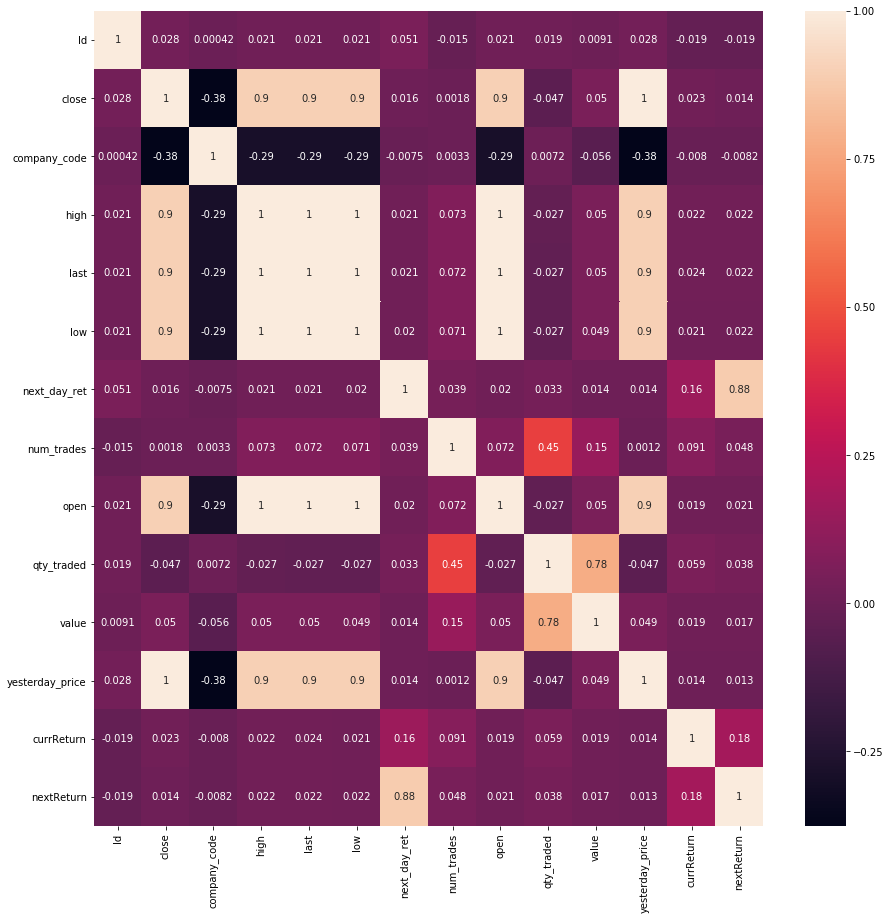

In [6]:
corrMatrix = all_data[:train_len].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, annot=True)

plt.show()

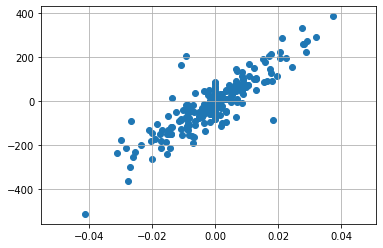

In [7]:
#I choose ADWYA for example
x = all_data[:train_len][all_data[:train_len].company=='ADWYA']['nextReturn'] 
y = all_data[:train_len][all_data[:train_len].company=='ADWYA']['next_day_ret'] 
plt.scatter(x,y)
plt.grid()
plt.show()

- We notice that yesterday_price, open, last, close, low, high are highly correlated.


- qty_traded and value are very correlated => We can actually drop the value column.


- next_day_ret and currReturn aren't very correlated, but we can try to generate features that might increase the correlation.


- next_day_ret and nextReturn are lineary correlated, but nextReturn requires knowning the future (day N+1) so we can't use nextReturn to predict next_day_ret. Unless we build a model that predicts nextReturn then make another model that predicts next_day_ret with the predicted values of nextReturn, but I didn't choose this approach. I decided to forecast directly next_day_ret.    

Lets see the relationships between price of current trading session features ('yesterday_price', 'open', 'last', 'close', 'low', 'high', 'qty_traded', 'num_trades', 'value') for the company ADWYA

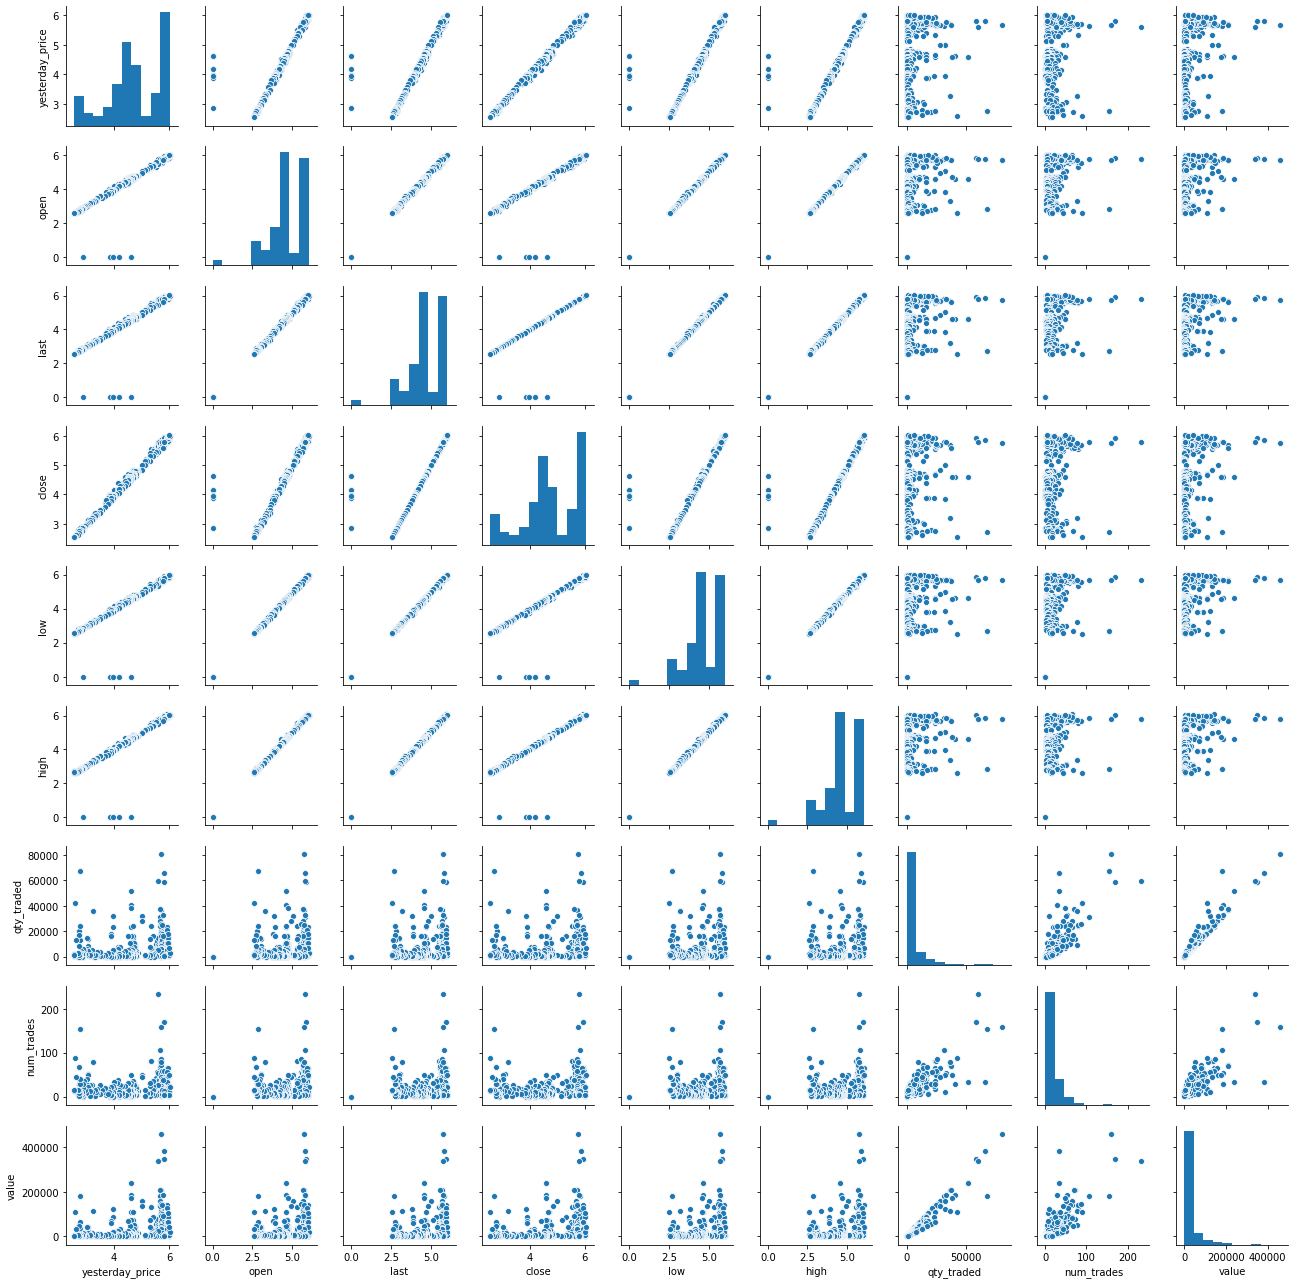

In [8]:
sns.pairplot(all_data.loc[all_data.company == 'ADWYA',['yesterday_price', 'open', 'last', 'close', 'low', 'high', 'qty_traded', 'num_trades', 'value']],height=2);

Its better if we drop the value column, since it doesn't provide much information its lineray correlated with qty_trades.

In [9]:
all_data.drop('value', axis = 1, inplace = True)

Lets take a look to the distributions of nummerical features.

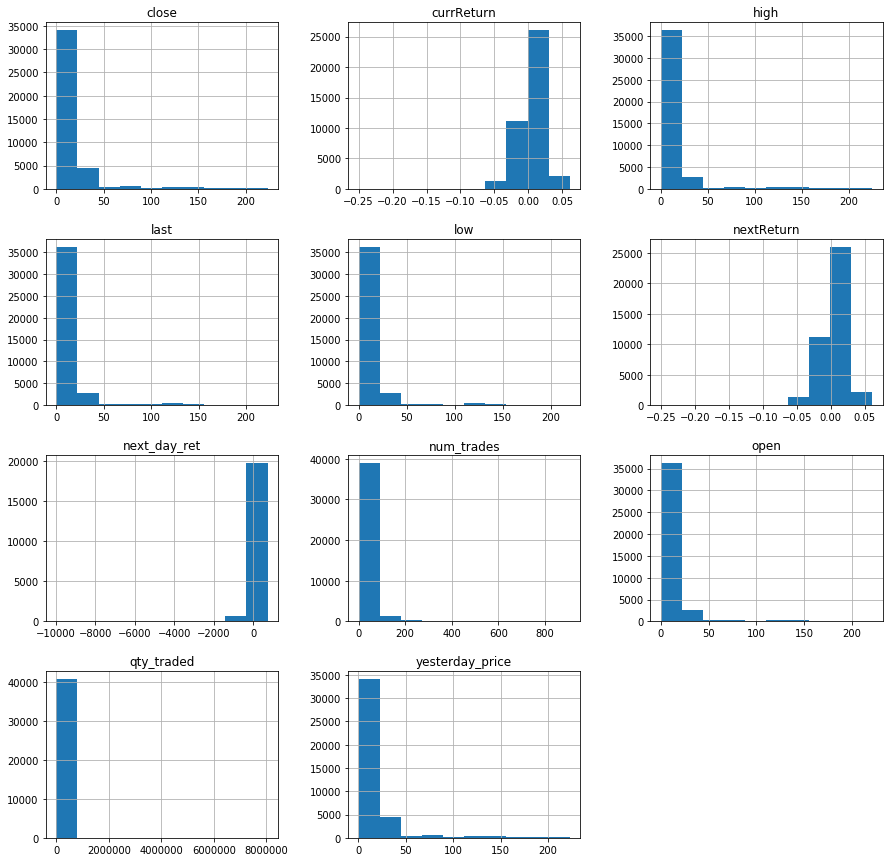

In [10]:
nummeric_features = ['yesterday_price', 'open', 'last', 'close', 'low', 'high', 
                      'num_trades', 'qty_traded','currReturn','nextReturn','next_day_ret']
all_data[nummeric_features].hist(figsize=(15,15))
plt.show()

Lets take a closer look to the target 'next_day_ret' distribution in the training set, and determine if there's potential outliers to replace.

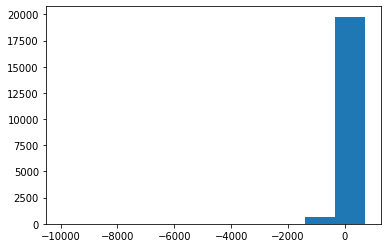

In [11]:
test = all_data[train_len:]
train = all_data[:train_len]
plt.hist(train['next_day_ret'])
plt.show()

In [12]:
train.next_day_ret.describe()

count    20417.000000
mean        -4.913852
std        192.123713
min      -9984.166026
25%        -79.763832
50%        -10.550777
75%         59.816971
max        718.817714
Name: next_day_ret, dtype: float64

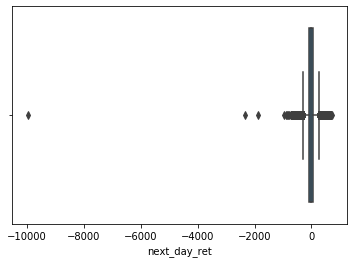

In [13]:
sns.boxplot(train['next_day_ret'] )

As we can see from the histogram, the boxplot and the data descriptive statistics, there's very large values of next_day_ret that can't even be possible so its better to replace these values with the mean value.

In [14]:
train[train['next_day_ret'] < -1000]

,Id,close,company,company_code,date,high,last,low,next_day_ret,num_trades,open,qty_traded,yesterday_price,currReturn,nextReturn
6671,6671,24.20,SFBT,110025,2018-04-27,24.20,24.20,23.90,-1867.193152,113,24.00,19133,23.94,0.010860,-0.186777
6900,6900,10.58,BT,220005,2018-05-03,10.60,10.58,10.48,-2347.097753,149,10.48,67111,10.47,0.010506,-0.232514
10851,10851,11.19,POULINA GP HOLDING,570001,2018-07-11,11.19,11.19,10.90,-9984.166026,7,11.19,6103,11.20,-0.000893,-0.000894


In [15]:
mean = train.loc[train['next_day_ret'] > -1000]['next_day_ret'].mean()
train.loc[train['next_day_ret'] < -1000, 'next_day_ret'] = np.nan
train['next_day_ret'].fillna(mean,inplace=True)

The new next_day_ret distribution, centred in 0.

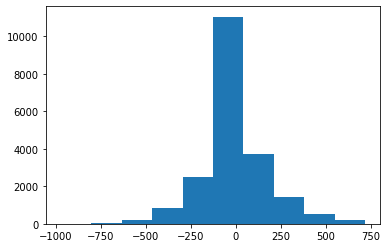

In [16]:
plt.hist(train.next_day_ret)
plt.show()

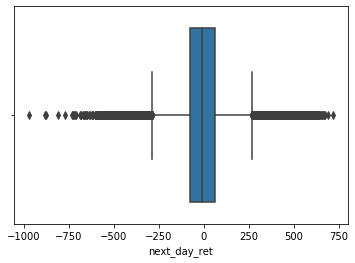

In [17]:
sns.boxplot(all_data['next_day_ret'])

In [18]:
all_data = pd.concat([train,test])
all_data.head()

,Id,close,company,company_code,date,high,last,low,next_day_ret,num_trades,open,qty_traded,yesterday_price,currReturn,nextReturn
0,0,5.39,ADWYA,725001,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,2926,5.35,NaN,-0.007421
1,1,24.00,AMEN BANK,340005,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,1519,24.35,NaN,-0.000417
2,2,6.10,ARTES,730001,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,35875,6.20,NaN,0.024590
3,3,9.00,ASSAD,714001,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,0,9.00,NaN,-0.001111
4,4,4.18,ATB,360035,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,3705,4.22,NaN,-0.007177


Since company can't be used to generate our linear model (linear model requires nummerical values), and company_code isn't very helpful, I replaced company_code with numbers from 0 to 82 to denote the 82 companies. I used preprocessing package from sklearn.

In [19]:
from sklearn import preprocessing


label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(all_data['company'].astype('str'))
all_data['num_company'] = label_encoder.transform(all_data['company'].astype('str').fillna('-1'))

all_data.head()

,Id,close,company,company_code,date,high,last,low,next_day_ret,num_trades,open,qty_traded,yesterday_price,currReturn,nextReturn,num_company
0,0,5.39,ADWYA,725001,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,2926,5.35,NaN,-0.007421,0
1,1,24.00,AMEN BANK,340005,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,1519,24.35,NaN,-0.000417,4
2,2,6.10,ARTES,730001,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,35875,6.20,NaN,0.024590,6
3,3,9.00,ASSAD,714001,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,0,9.00,NaN,-0.001111,8
4,4,4.18,ATB,360035,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,3705,4.22,NaN,-0.007177,10


In [20]:
all_data.drop(['company_code'], axis=1, inplace =True)

## Feature engineering
###### Date related features

In [21]:
all_data['month'] = all_data['date'].dt.month 
all_data['is_month_start'] = (all_data['date'].dt.is_month_start).astype('int')
all_data['is_month_end'] = (all_data['date'].dt.is_month_end).astype('int')

all_data['day'] = all_data['date'].dt.day
all_data['dayofyear'] = all_data['date'].dt.dayofyear
all_data['dayofweek'] = all_data['date'].dt.dayofweek  

all_data['quarter'] = all_data['date'].dt.quarter
all_data['is_quarter_start'] = (all_data['date'].dt.is_quarter_start).astype('int')
all_data['is_quarter_end'] = (all_data['date'].dt.is_quarter_end).astype('int')

all_data['is_year_start'] = (all_data['date'].dt.is_year_start).astype('int')
all_data['is_year_end'] = (all_data['date'].dt.is_year_end).astype('int')

list_date_features = ['month','day','dayofyear','dayofyear','quarter','is_month_start',
                      'is_month_end','is_year_start', 'is_year_end']

In [22]:
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,is_month_start,is_month_end,day,dayofyear,dayofweek,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,0,5.39,ADWYA,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,...,0,0,2,2,1,1,0,0,0,0
1,1,24.00,AMEN BANK,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,...,0,0,2,2,1,1,0,0,0,0
2,2,6.10,ARTES,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,...,0,0,2,2,1,1,0,0,0,0
3,3,9.00,ASSAD,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,...,0,0,2,2,1,1,0,0,0,0
4,4,4.18,ATB,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,...,0,0,2,2,1,1,0,0,0,0


###### Power of currReturn

In [23]:
all_data['currReturn2'] = all_data['currReturn']*all_data['currReturn']
all_data['currReturn3'] = all_data['currReturn2']*all_data['currReturn']
all_data['currReturn4'] = all_data['currReturn3']*all_data['currReturn']


###### currReturn of the previous 7 days

In [24]:
all_data['currReturn_1'] = all_data['currReturn'].shift(1)
all_data['currReturn_2'] = all_data['currReturn'].shift(2)
all_data['currReturn_3'] = all_data['currReturn'].shift(3)
all_data['currReturn_4'] = all_data['currReturn'].shift(4)
all_data['currReturn_5'] = all_data['currReturn'].shift(5)
all_data['currReturn_6'] = all_data['currReturn'].shift(6)
all_data['currReturn_7'] = all_data['currReturn'].shift(7)

###### Feature that denotes the sector
I used data from https://www.ilboursa.com/marches/secteurs.aspx

In [25]:
FOOD =['CEREALIS','DELICE HOLDING','ELBENE INDUSTRIE','LAND OR','POULINA GP HOLDING','SFBT','SOPAT','STE TUN. DU SUCRE']

AUTO = ['ASSAD','GIF-FILTER','STEQ','STIP']

BANKS = ['AMEN BANK','ATB','ATTIJARI BANK','BT','BH',
         'BTE (ADP)','BNA','BIAT','STB',
         'UBCI','UIB','WIFACK INT BANK']
CONSTRUCT = ['ESSOUKNA','SANIMED','SIMPAR','SITS','SOMOCER','SOTEMAIL']

TECH =['AETECH','EURO-CYCLES','HEXABYTE','ONE TECH HOLDING','TELNET HOLDING','SERVICOM','SOTETEL','TAWASOL']

FINANCE = ['ARAB TUNISIAN LEASE','BEST LEASE','CIL','HANNIBAL LEASE','MODERN LEASING','TAWASOL GP HOLDING',
           'PLACEMENTS DE TUNISIE - SICAF','SPDIT - SICAF','TUNINVEST - SICAR','TUNISIE LEASING & FACTORING',
           'ATTIJARI LEASING','ATL','TAWASOL GP HOLDING','TUNISIE VALEURS','ASS MULTI ITTIHAD',
           'TUNINVEST-SICAR','PLAC. TSIE-SICAF','MAGHREB INTERN PUB','TUNISAIR']

INSURANCE = ['AMI','ASTREE','BH ASSURANCE','STAR','TUNIS RE']

INDUS = ['AMS','SIAME','SOTUVER','MIP','MPBS','SOTIPAPIER','ATELIER MEUBLE INT',
         'ELECTROSTAR','SOTRAPIL' ,'OFFICEPLAST',"NEW BODY LINE"]

DISTRIBUTION =['ARTES','CELLCOM','CITY CARS','ENNAKL AUTOMOBILES','MAGASIN GENERAL',
               'MEUBLES INTERIEURS','MONOPRIX','SAH','SOTUMAG','UADH','SITEX']

PHARMACEUTICAL = ['ADWYA','SIPHAT','UNIMED','AIR LIQUDE TSIE','ICF','ALKIMIA']

RAW =['CARTHAGE CEMENT','CIMENTS DE BIZERTE','TPR']


In [26]:
all_companies = set(all_data['company'].unique().tolist())

FOOD=list(set(FOOD).intersection(all_companies))
print('FOOD :',FOOD)

AUTO=list(set(AUTO).intersection(all_companies))
print('AUTO :',AUTO)

BANKS=list(set(BANKS).intersection(all_companies))
print('BANKS :',BANKS)

CONSTRUCT=list(set(CONSTRUCT).intersection(all_companies))
print('CONSTRUCT :',CONSTRUCT)

TECH=list(set(TECH).intersection(all_companies))
print('TECH :',TECH)

FINANCE=list(set(FINANCE).intersection(all_companies))
print('FINANCE :',FINANCE)

INSURANCE=list(set(INSURANCE).intersection(all_companies))
print('INSURANCE :',INSURANCE)

INDUS=list(set(INDUS).intersection(all_companies))
print('INDUS :',INDUS)

PHARMACEUTICAL=list(set(PHARMACEUTICAL).intersection(all_companies))
print('PHARMACEUTICAL :',PHARMACEUTICAL)

RAW=list(set(RAW).intersection(all_companies))
print('RAW :',RAW)

DISTRIBUTION=list(set(DISTRIBUTION).intersection(all_companies))
print('DISTRIBUTION :',DISTRIBUTION)

FOOD : ['LAND OR', 'SOPAT', 'DELICE HOLDING', 'POULINA GP HOLDING', 'STE TUN. DU SUCRE', 'SFBT', 'CEREALIS', 'ELBENE INDUSTRIE']
AUTO : ['GIF-FILTER', 'ASSAD', 'STEQ', 'STIP']
BANKS : ['BNA', 'BT', 'UIB', 'ATTIJARI BANK', 'STB', 'ATB', 'BIAT', 'AMEN BANK', 'BTE (ADP)', 'WIFACK INT BANK', 'UBCI', 'BH']
CONSTRUCT : ['ESSOUKNA', 'SITS', 'SANIMED', 'SIMPAR', 'SOTEMAIL', 'SOMOCER']
TECH : ['EURO-CYCLES', 'TELNET HOLDING', 'SERVICOM', 'ONE TECH HOLDING', 'AETECH', 'SOTETEL', 'HEXABYTE']
FINANCE : ['TUNINVEST-SICAR', 'PLAC. TSIE-SICAF', 'MODERN LEASING', 'TAWASOL GP HOLDING', 'HANNIBAL LEASE', 'CIL', 'ATTIJARI LEASING', 'MAGHREB INTERN PUB', 'ASS MULTI ITTIHAD', 'ATL', 'TUNISAIR', 'BEST LEASE', 'SPDIT - SICAF']
INSURANCE : ['ASTREE', 'STAR', 'TUNIS RE']
INDUS : ['SIAME', 'SOTIPAPIER', 'AMS', 'NEW BODY LINE', 'MPBS', 'SOTRAPIL', 'OFFICEPLAST', 'ATELIER MEUBLE INT', 'SOTUVER', 'ELECTROSTAR']
PHARMACEUTICAL : ['UNIMED', 'AIR LIQUDE TSIE', 'ADWYA', 'ICF', 'SIPHAT', 'ALKIMIA']
RAW : ['CIMENTS DE B

In [27]:
all_company = [FOOD,AUTO,BANKS,CONSTRUCT,TECH,FINANCE,INSURANCE,INDUS,DISTRIBUTION,PHARMACEUTICAL,RAW]

In [28]:
l = set() 
for i in all_company : 
    l = l.union(i)

all_company = list(l)
set(all_company).difference(all_companies)

set()

In [29]:
company_map = dict() 
all_company = {'FOOD':FOOD,'AUTO':AUTO,'BANKS':BANKS,'CONSTRUCT':CONSTRUCT,'TECH':TECH
               ,'FINANCE':FINANCE,'INSURANCE':INSURANCE,'INDUS':INDUS,
               'DISTRIBUTION':DISTRIBUTION,'PHARMACEUTICAL':PHARMACEUTICAL,'RAW':RAW}

for sector in all_company.keys() : 
    for company in all_company[sector] : 
        company_map[company] = sector
all_data['sector'] = all_data['company'].map(company_map)


In [30]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(all_data['sector'].astype('str'))
all_data['num_sector'] = label_encoder.transform(all_data['sector'].astype('str').fillna('-1'))
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,currReturn4,currReturn_1,currReturn_2,currReturn_3,currReturn_4,currReturn_5,currReturn_6,currReturn_7,sector,num_sector
0,0,5.39,ADWYA,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHARMACEUTICAL,8
1,1,24.00,AMEN BANK,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BANKS,1
2,2,6.10,ARTES,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DISTRIBUTION,3
3,3,9.00,ASSAD,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTO,0
4,4,4.18,ATB,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BANKS,1


##### Power of price related features

In [31]:
all_data['yesterday_price2'] = all_data['yesterday_price']*all_data['yesterday_price']
all_data['open2'] = all_data['open']*all_data['open']
all_data['last2'] = all_data['last']*all_data['last']
all_data['close2'] = all_data['close']*all_data['close']
all_data['low2'] = all_data['low']*all_data['low']
all_data['high2'] = all_data['high']*all_data['high']

all_data['yesterday_price3'] = all_data['yesterday_price2'] * all_data['yesterday_price']
all_data['open3'] = all_data['open2'] * all_data['open']
all_data['last3'] = all_data['last2'] * all_data['last']
all_data['close3'] = all_data['close2']*all_data['close']
all_data['low3'] = all_data['low2'] * all_data['low']
all_data['high3'] = all_data['high2']*all_data['high']

In [32]:
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,last2,close2,low2,high2,yesterday_price3,open3,last3,close3,low3,high3
0,0,5.39,ADWYA,2018-01-02,5.39,5.39,5.25,-161.101159,7,5.25,...,29.0521,29.0521,27.5625,29.0521,153.130375,144.703125,156.590819,156.590819,144.703125,156.590819
1,1,24.00,AMEN BANK,2018-01-02,24.38,24.00,24.00,-91.056323,12,24.38,...,576.0000,576.0000,576.0000,594.3844,14437.662875,14491.091672,13824.000000,13824.000000,13824.000000,14491.091672
2,2,6.10,ARTES,2018-01-02,6.27,6.10,6.09,159.011983,67,6.27,...,37.2100,37.2100,37.0881,39.3129,238.328000,246.491883,226.981000,226.981000,225.866529,246.491883
3,3,9.00,ASSAD,2018-01-02,0.00,0.00,0.00,-98.000768,0,0.00,...,0.0000,81.0000,0.0000,0.0000,729.000000,0.000000,0.000000,729.000000,0.000000,0.000000
4,4,4.18,ATB,2018-01-02,4.18,4.18,4.15,-158.659992,7,4.15,...,17.4724,17.4724,17.2225,17.4724,75.151448,71.473375,73.034632,73.034632,71.473375,73.034632


## Features scaling

Its better that all features have the same range so I used min-max scaling. It scales and translates each feature individually such that it is in the given range on the dataset, e.g. between zero and one.

In [33]:
all_data.dtypes

Id                           int64
close                      float64
company                     object
date                datetime64[ns]
high                       float64
last                       float64
low                        float64
next_day_ret               float64
num_trades                   int64
open                       float64
qty_traded                   int64
yesterday_price            float64
currReturn                 float64
nextReturn                 float64
num_company                  int32
month                        int64
is_month_start               int32
is_month_end                 int32
day                          int64
dayofyear                    int64
dayofweek                    int64
quarter                      int64
is_quarter_start             int32
is_quarter_end               int32
is_year_start                int32
is_year_end                  int32
currReturn2                float64
currReturn3                float64
currReturn4         

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col_scal_list = ['close', 'high', 'last', 'low', 'num_trades', 'open', 
                 'qty_traded', 'yesterday_price', 'currReturn',
                 'nextReturn', 'currReturn2','currReturn3', 'currReturn4', 
                 'currReturn_1', 'currReturn_2', 'currReturn_3', 
                 'currReturn_4', 'currReturn_5', 'currReturn_6',
                 'currReturn_7', 'yesterday_price2', 'open2', 'last2', 
                 'close2', 'low2', 'high2', 'yesterday_price3', 'open3',
                'last3', 'close3', 'low3', 'high3']

scaler.fit(all_data[col_scal_list])
all_data[col_scal_list] = scaler.transform(all_data[col_scal_list])
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,last2,close2,low2,high2,yesterday_price3,open3,last3,close3,low3,high3
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,0.000585,0.000584,0.000569,0.000574,0.000014,0.000013,0.000014,0.000014,0.000014,0.000014
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,0.011593,0.011592,0.011899,0.011741,0.001304,0.001339,0.001248,0.001248,0.001298,0.001272
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,0.000749,0.000748,0.000766,0.000777,0.000022,0.000023,0.000020,0.000020,0.000021,0.000022
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,0.000000,0.001629,0.000000,0.000000,0.000066,0.000000,0.000000,0.000066,0.000000,0.000000
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,0.000352,0.000351,0.000356,0.000345,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006


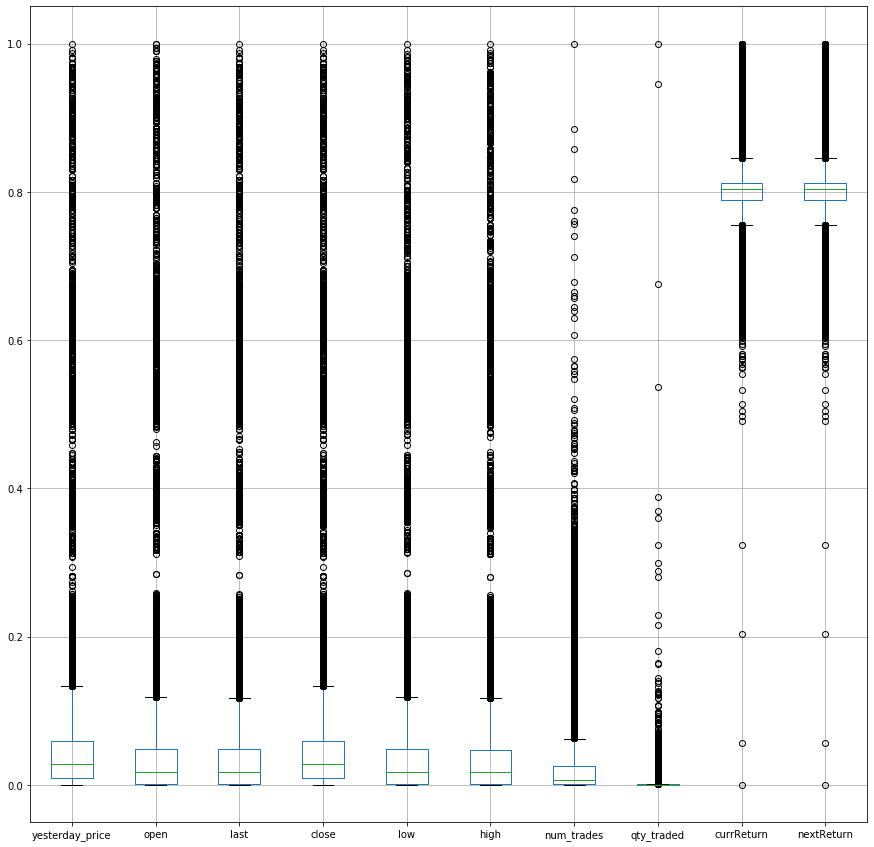

In [35]:
nummeric_features.remove('next_day_ret')
all_data[nummeric_features].boxplot(figsize=(15,15))

In the boxplots above we can see some features distributions after scaling.

## More feature engineering

I tried using the mean, min and max on currReturn and on groups of some relevant features of the dataset, to generate new features that helps in predicting the target.

In [36]:
#mean of currReturn on data grouped by sector
new = all_data.groupby((['sector']))['currReturn'].agg({'mean'})
name = 'sector_mean_currReturn'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['sector'])

#mean of currReturn on data grouped by company
new = all_data.groupby((['company']))['currReturn'].agg({'mean'})
name = 'company_mean_currReturn'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['company'])


#max of currReturn on data grouped by sector
new = all_data.groupby((['sector']))['currReturn'].agg({'max'})
name = 'sector_max_currReturn'
new.rename(columns={"max": name},  inplace = True)
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['sector'])

#max of currReturn on data grouped by company
new = all_data.groupby((['company']))['currReturn'].agg({'max'})
name = 'company_max_currReturn'
new.rename(columns={"max": name},  inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['company'])


#mean of currReturn on data grouped by month and company
new = all_data.groupby((['company', 'month']))['currReturn'].agg({'mean'})
name = 'company_mean_currReturn_month'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data,new , how='left', on = ['company','month'])

#mean of currReturn on data grouped by month and sector
new = all_data.groupby((['sector','month']))['currReturn'].agg({'mean'})
name = 'sector_mean_currReturn_month'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data,new , how='left', on = ['sector','month'])

#mean of currReturn_1 on data grouped by sector
new = all_data.groupby((['sector']))['currReturn_1'].agg({'mean'})
name = 'sector_mean_currReturn_1'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['sector'])

#mean of currReturn_7 on data grouped by sector
new = all_data.groupby((['sector']))['currReturn_7'].agg({'mean'})
name = 'sector_mean_currReturn_7'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['sector'])


#mean of currReturn_1 on data grouped by company
new = all_data.groupby((['company']))['currReturn_1'].agg({'mean'})
name = 'company_mean_currReturn_1'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['company'])

#mean of currReturn_7 on data grouped by company
new = all_data.groupby((['company']))['currReturn_1'].agg({'mean'})
name = 'company_mean_currReturn_7'
new.rename(columns={"mean": name}, inplace = True) 
new = new.reset_index()
all_data = pd.merge(all_data, new, how='left', on = ['company'])



The mean, min and max on the 7 previous currReturn of each day.

In [37]:
all_data['mean_7_currReturn'] = all_data[['currReturn_1', 'currReturn_2', 'currReturn_3', 
                                          'currReturn_4','currReturn_5', 'currReturn_6', 'currReturn_7']].mean(axis=1)
all_data['max_7_currReturn'] = all_data[['currReturn_1', 'currReturn_2', 'currReturn_3', 
                                          'currReturn_4','currReturn_5', 'currReturn_6', 'currReturn_7']].max(axis=1)
all_data['min_7_currReturn'] = all_data[['currReturn_1', 'currReturn_2', 'currReturn_3', 
                                          'currReturn_4','currReturn_5', 'currReturn_6', 'currReturn_7']].min(axis=1)


In [38]:
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,company_max_currReturn,company_mean_currReturn_month,sector_mean_currReturn_month,sector_mean_currReturn_1,sector_mean_currReturn_7,company_mean_currReturn_1,company_mean_currReturn_7,mean_7_currReturn,max_7_currReturn,min_7_currReturn
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,0.989703,0.811791,0.809315,0.803456,0.804407,0.804653,0.804653,NaN,NaN,NaN
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,0.900630,0.801849,0.805335,0.802828,0.805212,0.799589,0.799589,NaN,NaN,NaN
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,0.935514,0.811263,0.802345,0.803513,0.803485,0.805532,0.805532,NaN,NaN,NaN
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,0.999312,0.813073,0.807101,0.803890,0.800407,0.802817,0.802817,NaN,NaN,NaN
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,0.998421,0.802506,0.805335,0.802828,0.805212,0.803129,0.803129,NaN,NaN,NaN


## Dimension reduction (PCA) 

In [39]:
all_data.columns

Index(['Id', 'close', 'company', 'date', 'high', 'last', 'low', 'next_day_ret',
       'num_trades', 'open', 'qty_traded', 'yesterday_price', 'currReturn',
       'nextReturn', 'num_company', 'month', 'is_month_start', 'is_month_end',
       'day', 'dayofyear', 'dayofweek', 'quarter', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'currReturn2',
       'currReturn3', 'currReturn4', 'currReturn_1', 'currReturn_2',
       'currReturn_3', 'currReturn_4', 'currReturn_5', 'currReturn_6',
       'currReturn_7', 'sector', 'num_sector', 'yesterday_price2', 'open2',
       'last2', 'close2', 'low2', 'high2', 'yesterday_price3', 'open3',
       'last3', 'close3', 'low3', 'high3', 'sector_mean_currReturn',
       'company_mean_currReturn', 'sector_max_currReturn',
       'company_max_currReturn', 'company_mean_currReturn_month',
       'sector_mean_currReturn_month', 'sector_mean_currReturn_1',
       'sector_mean_currReturn_7', 'company_mean_currReturn_1',
       'c

###### Reducing dimension for date features related 

In [40]:
num_pc = 1

comp_data = all_data[list_date_features]

pca = PCA(n_components=num_pc) 
pca.fit(comp_data.values)

components = pca.transform(comp_data.values)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by just one PC'.format(percentage_cum[-1]*100))

col = ['date_PC1']
pca_components = pd.DataFrame(data = components , columns=col  )
pca_components['index'] = comp_data.index
pca_components = pca_components.set_index('index')

99.66% of the variance is explained by just one PC


In [41]:
all_data = pd.concat([all_data, pca_components],axis=1)
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,company_mean_currReturn_month,sector_mean_currReturn_month,sector_mean_currReturn_1,sector_mean_currReturn_7,company_mean_currReturn_1,company_mean_currReturn_7,mean_7_currReturn,max_7_currReturn,min_7_currReturn,date_PC1
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,0.811791,0.809315,0.803456,0.804407,0.804653,0.804653,NaN,NaN,NaN,-255.926424
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,0.801849,0.805335,0.802828,0.805212,0.799589,0.799589,NaN,NaN,NaN,-255.926424
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,0.811263,0.802345,0.803513,0.803485,0.805532,0.805532,NaN,NaN,NaN,-255.926424
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,0.813073,0.807101,0.803890,0.800407,0.802817,0.802817,NaN,NaN,NaN,-255.926424
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,0.802506,0.805335,0.802828,0.805212,0.803129,0.803129,NaN,NaN,NaN,-255.926424


###### Reducing dimension of the price related features

In [42]:
num_pc = 2

comp_data = all_data[['yesterday_price', 'open', 'last', 'close', 'low','high']]
pca = PCA(n_components=num_pc) 
pca.fit(comp_data.values)

components = pca.transform(comp_data.values)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by 2 PCs'.format(percentage_cum[-1]*100))

col = ['stock_PC1', 'stock_PC2']
pca_components = pd.DataFrame(data = components , columns=col  )
pca_components['index'] = comp_data.index
pca_components = pca_components.set_index('index')

99.99% of the variance is explained by 2 PCs


In [43]:
all_data = pd.concat([all_data, pca_components],axis=1)
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,sector_mean_currReturn_1,sector_mean_currReturn_7,company_mean_currReturn_1,company_mean_currReturn_7,mean_7_currReturn,max_7_currReturn,min_7_currReturn,date_PC1,stock_PC1,stock_PC2
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,0.803456,0.804407,0.804653,0.804653,NaN,NaN,NaN,-255.926424,-0.078956,-0.017566
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,0.802828,0.805212,0.799589,0.799589,NaN,NaN,NaN,-255.926424,0.128630,-0.019689
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,0.803513,0.803485,0.805532,0.805532,NaN,NaN,NaN,-255.926424,-0.069760,-0.018075
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,0.803890,0.800407,0.802817,0.802817,NaN,NaN,NaN,-255.926424,-0.104369,0.029090
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,0.802828,0.805212,0.803129,0.803129,NaN,NaN,NaN,-255.926424,-0.091728,-0.017537


###### Reducing dimension of the power 2 price related features

In [44]:
num_pc = 2

comp_data = all_data[['yesterday_price2', 'open2', 'last2', 'close2', 'low2','high2']]
pca = PCA(n_components=num_pc) 
pca.fit(comp_data.values)

components = pca.transform(comp_data.values)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by 2 PCs'.format(percentage_cum[-1]*100))

col = ['stock2_PC1', 'stock2_PC2']
pca_components = pd.DataFrame(data = components , columns=col  )
pca_components['index'] = comp_data.index
pca_components = pca_components.set_index('index')

99.97% of the variance is explained by 2 PCs


In [45]:
all_data = pd.concat([all_data, pca_components],axis=1)
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,company_mean_currReturn_1,company_mean_currReturn_7,mean_7_currReturn,max_7_currReturn,min_7_currReturn,date_PC1,stock_PC1,stock_PC2,stock2_PC1,stock2_PC2
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,0.804653,0.804653,NaN,NaN,NaN,-255.926424,-0.078956,-0.017566,-0.040399,-0.003441
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,0.799589,0.799589,NaN,NaN,NaN,-255.926424,0.128630,-0.019689,-0.012860,-0.003774
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,0.805532,0.805532,NaN,NaN,NaN,-255.926424,-0.069760,-0.018075,-0.039923,-0.003468
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,0.802817,0.802817,NaN,NaN,NaN,-255.926424,-0.104369,0.029090,-0.040461,-0.001566
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,0.803129,0.803129,NaN,NaN,NaN,-255.926424,-0.091728,-0.017537,-0.040945,-0.003440


###### Reducing dimension of the power 3 price related features

In [46]:
num_pc = 2

comp_data = all_data[['yesterday_price3', 'open3', 'last3', 'close3', 'low3','high3']]
pca = PCA(n_components=num_pc) 
pca.fit(comp_data.values)

components = pca.transform(comp_data.values)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by 2 PCs'.format(percentage_cum[-1]*100))

col = ['stock3_PC1', 'stock3_PC2']
pca_components = pd.DataFrame(data = components , columns=col  )
pca_components['index'] = comp_data.index
pca_components = pca_components.set_index('index')

99.93% of the variance is explained by 2 PCs


In [47]:
all_data = pd.concat([all_data, pca_components],axis=1)
all_data.head()

,Id,close,company,date,high,last,low,next_day_ret,num_trades,open,...,mean_7_currReturn,max_7_currReturn,min_7_currReturn,date_PC1,stock_PC1,stock_PC2,stock2_PC1,stock2_PC2,stock3_PC1,stock3_PC2
0,0,0.023217,ADWYA,2018-01-02,0.023956,0.024181,0.023861,-161.101159,0.007726,0.023735,...,NaN,NaN,NaN,-255.926424,-0.078956,-0.017566,-0.040399,-0.003441,-0.023910,-0.001251
1,1,0.106790,AMEN BANK,2018-01-02,0.108356,0.107672,0.109081,-91.056323,0.013245,0.110222,...,NaN,NaN,NaN,-255.926424,0.128630,-0.019689,-0.012860,-0.003774,-0.020796,-0.001277
2,2,0.026406,ARTES,2018-01-02,0.027867,0.027367,0.027679,159.011983,0.073951,0.028347,...,NaN,NaN,NaN,-255.926424,-0.069760,-0.018075,-0.039923,-0.003468,-0.023891,-0.001252
3,3,0.039429,ASSAD,2018-01-02,0.000000,0.000000,0.000000,-98.000768,0.000000,0.000000,...,NaN,NaN,NaN,-255.926424,-0.104369,0.029090,-0.040461,-0.001566,-0.023890,-0.001175
4,4,0.017783,ATB,2018-01-02,0.018578,0.018753,0.018862,-158.659992,0.007726,0.018762,...,NaN,NaN,NaN,-255.926424,-0.091728,-0.017537,-0.040945,-0.003440,-0.023928,-0.001251


## Modeling part

In [48]:
all_data.columns

Index(['Id', 'close', 'company', 'date', 'high', 'last', 'low', 'next_day_ret',
       'num_trades', 'open', 'qty_traded', 'yesterday_price', 'currReturn',
       'nextReturn', 'num_company', 'month', 'is_month_start', 'is_month_end',
       'day', 'dayofyear', 'dayofweek', 'quarter', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'currReturn2',
       'currReturn3', 'currReturn4', 'currReturn_1', 'currReturn_2',
       'currReturn_3', 'currReturn_4', 'currReturn_5', 'currReturn_6',
       'currReturn_7', 'sector', 'num_sector', 'yesterday_price2', 'open2',
       'last2', 'close2', 'low2', 'high2', 'yesterday_price3', 'open3',
       'last3', 'close3', 'low3', 'high3', 'sector_mean_currReturn',
       'company_mean_currReturn', 'sector_max_currReturn',
       'company_max_currReturn', 'company_mean_currReturn_month',
       'sector_mean_currReturn_month', 'sector_mean_currReturn_1',
       'sector_mean_currReturn_7', 'company_mean_currReturn_1',
       'c

In [49]:
liste=['date_PC1','stock_PC1', 'stock_PC2', 'stock2_PC1', 'stock2_PC2', 'stock3_PC1', 'stock3_PC2',
       'qty_traded', 'num_trades','num_company','num_sector', 
       'currReturn_1', 'currReturn_3', 'currReturn_7','currReturn',
       'currReturn2','currReturn3', 'currReturn4', 'next_day_ret', 
       'sector_mean_currReturn','company_mean_currReturn', 'sector_max_currReturn',
       'company_max_currReturn', 'company_mean_currReturn_month',
       'sector_mean_currReturn_month', 'sector_mean_currReturn_1',
       'sector_mean_currReturn_7', 'company_mean_currReturn_1',
       'company_mean_currReturn_7', 'mean_7_currReturn', 'max_7_currReturn',
       'min_7_currReturn' ]


train = all_data[:train_len][liste]
train.drop(train[train['currReturn_7'].isnull()].index, inplace=True)
train.isnull().sum().sum()

0

In [50]:
from sklearn.model_selection import train_test_split

y = train['next_day_ret']
liste.remove('next_day_ret')

X = train[liste]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = regression.linear_model.OLS(np.asarray(y_train), np.asarray(X_train)).fit()
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred, y_test))


167.14071886806516

In [51]:
test = all_data[train_len:][liste]
test.head()

,date_PC1,stock_PC1,stock_PC2,stock2_PC1,stock2_PC2,stock3_PC1,stock3_PC2,qty_traded,num_trades,num_company,...,company_max_currReturn,company_mean_currReturn_month,sector_mean_currReturn_month,sector_mean_currReturn_1,sector_mean_currReturn_7,company_mean_currReturn_1,company_mean_currReturn_7,mean_7_currReturn,max_7_currReturn,min_7_currReturn
20417,-255.926424,-0.085048,-0.018037,-0.040676,-0.003461,-0.023919,-0.001251,0.000534,0.005519,0,...,0.989703,0.811791,0.809315,0.803456,0.804407,0.804653,0.804653,0.771467,0.935421,0.660305
20418,-255.926424,0.167711,-0.019623,-0.003744,-0.003777,-0.019198,-0.001271,0.000032,0.009934,4,...,0.900630,0.801849,0.805335,0.802828,0.805212,0.799589,0.799589,0.786185,0.935421,0.660305
20419,-255.926424,-0.068600,-0.017931,-0.039858,-0.003460,-0.023889,-0.001251,0.000315,0.004415,6,...,0.935514,0.811263,0.802345,0.803513,0.803485,0.805532,0.805532,0.798873,0.935421,0.660305
20420,-255.926424,-0.050675,-0.018027,-0.038716,-0.003469,-0.023834,-0.001251,0.001849,0.068433,8,...,0.999312,0.813073,0.807101,0.803890,0.800407,0.802817,0.802817,0.812025,0.935421,0.660305
20421,-255.926424,-0.096912,-0.018074,-0.041128,-0.003459,-0.023932,-0.001251,0.000066,0.014349,10,...,0.998421,0.802506,0.805335,0.802828,0.805212,0.803129,0.803129,0.824986,0.935421,0.660305


In [52]:
modelgeneral = sample.copy()
pred = model.predict(test)
modelgeneral['next_day_ret'] = pred.values
modelgeneral.set_index('Id', inplace=True)
modelgeneral.to_csv('./submission.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBE7C9A408>]],
      dtype=object)

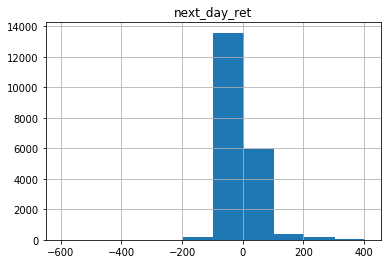

In [53]:
modelgeneral.hist()